In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output

#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    First_column=np.roll(Fourier_plus,-1)[::-1][:L]
    First_row = Fourier_plus[:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    First_column=Fourier_minous[::-1][:L]
    Last_row=np.roll(Fourier_minous,L-1)[::-1][:L]
    return hankel(First_column,Last_row)


def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L,N_size=N_size):
    return (Toeplitz_matrix(F_plus,L)+Hankel_matrix(F_minous,L))/N_size

In [2]:
N_size=5*int(10**4)+1
F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)

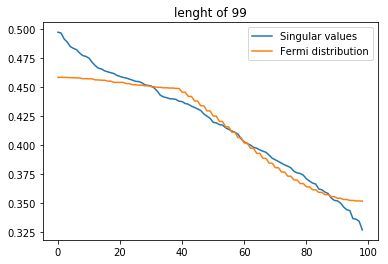

In [3]:
beta=0.40824
mu=0
import time
for L in range(7,101,2):
    clear_output(wait=True)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    S=np.linalg.svd(New_cov_matrix,compute_uv=False)
    n=np.arange(-(L-1)/2,(L-1)/2 +1)
    array_to_plot=sorted(-S+0.5,reverse=True)
    plt.plot(array_to_plot,label="Singular values")
    plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")
    plt.legend()
    plt.title("lenght of {}".format(L))
    plt.show()
    time.sleep(0.1)

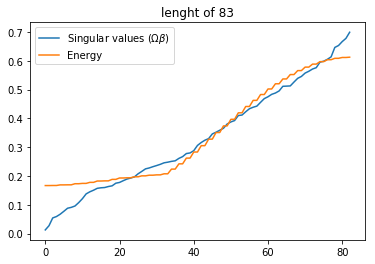

In [4]:
for L in range(3,85,2):
    clear_output(wait=True)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    S=np.linalg.svd(New_cov_matrix,compute_uv=False)
    n=np.arange(-(L-1)/2,(L-1)/2 +1)
    S=-S+0.5
    array_to_plot=sorted(np.log((1-S)/(S)))
    plt.plot(array_to_plot,label=r"Singular values ($\Omega\beta$)")
    plt.plot(sorted(beta*Omega(Gamma,Lambda,n/L * 2*np.pi)),label="Energy")
    plt.legend()
    plt.title("lenght of {}".format(L))
    plt.show()
    time.sleep(0.9)

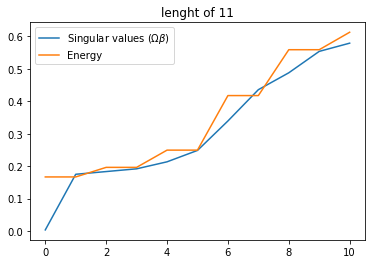

In [5]:
L=11
New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
S=np.linalg.svd(New_cov_matrix,compute_uv=False)
n=np.arange(-(L-1)/2,(L-1)/2 +1)
S=-S+0.5
array_to_plot=sorted(np.log((1-S)/(S)))
plt.plot(array_to_plot,label=r"Singular values ($\Omega\beta$)")
plt.plot(sorted(beta*Omega(Gamma,Lambda,n/L * 2*np.pi)),label="Energy")
plt.legend()
plt.title("lenght of {}".format(L))
plt.show()
time.sleep(0.9)

In [6]:
L=11
New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
O_1,S,O_2=np.linalg.svd(New_cov_matrix)
S=-S+0.5
#x=sorted(np.log((1-S)/(S)))
x=np.log((1-S)/(S))

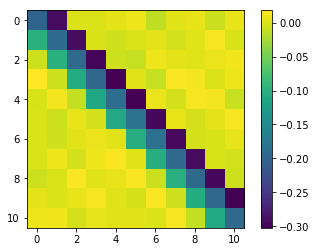

In [7]:
plt.imshow((O_1@np.diag(x)@O_2).real)
plt.colorbar()

In [8]:
from scipy.linalg import expm

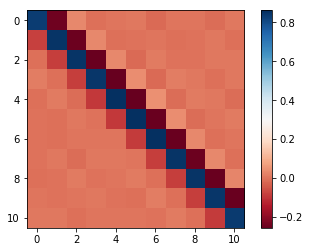

In [9]:
plt.imshow(expm((O_1@np.diag(x)@O_2)).real,cmap="RdBu")
plt.colorbar()

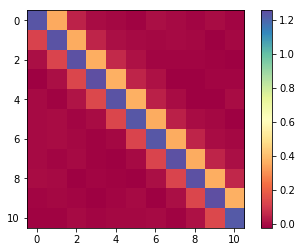

In [10]:
plt.imshow(expm(-(O_1@np.diag(x)@O_2)).real,cmap="Spectral")
plt.colorbar()

# If we do not sort it it seems that we do not have anything interesing, it seems to do not have the same structure as the Hamiltonian

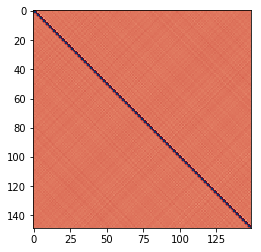

In [14]:
for L in range(3,151,2):
    clear_output(wait=True)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    S=-S+0.5
    x=np.log((1-S)/(S))
    plt.imshow(expm((O_1@np.diag(x)@O_2)).real,cmap="RdBu")
    #plt.colorbar()
    plt.show()
    time.sleep(0.5)

# If we sort them it seems to appear the structure of something like circulant

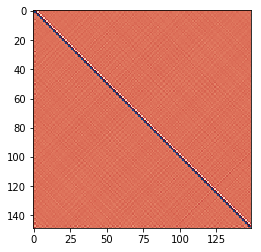

In [15]:
for L in range(3,151,2):
    clear_output(wait=True)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    S=-S+0.5
    x=sorted(np.log((1-S)/(S)))
    plt.imshow(expm((O_1@np.diag(x)@O_2)).real,cmap="RdBu")
    #plt.colorbar()
    plt.show()
    time.sleep(0.5)

In [91]:
from pylab import *
from numpy import outer
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(20,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cm.datad if not m.endswith("_r")]
maps.sort()
l=len(maps)+1
for i, m in enumerate(maps):
    subplot(1,l,i+1)
    axis("off")
    imshow(a,aspect='auto',cmap=get_cmap(m),origin="lower")
    title(m,rotation=90,fontsize=10)
savefig("colormaps.png",dpi=100,facecolor='gray')
close()

(-0.5, 499.5, 1999.5, -0.5)

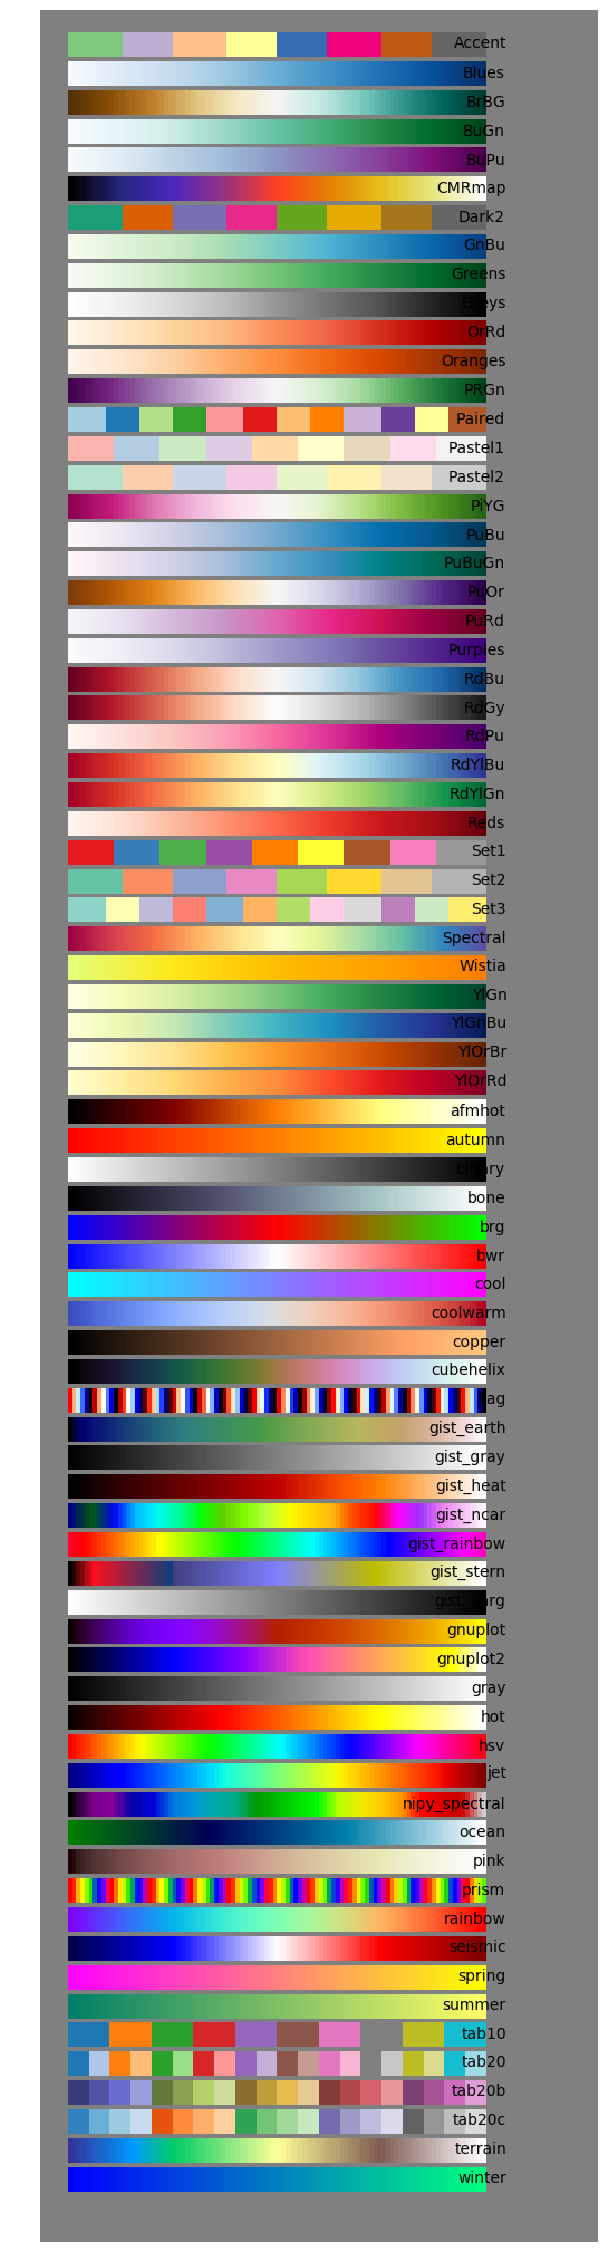

In [92]:
figure(figsize=(10,100))
imshow(np.fliplr(np.transpose(np.array(imread("colormaps.png")),[1,0,2])))
axis("off")